In [1]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_74269/83517159.py:18: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  names, varargs, keywords, defaults = inspect.getargspec(func)
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_74269/83517159.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8, 7), sharex=True)


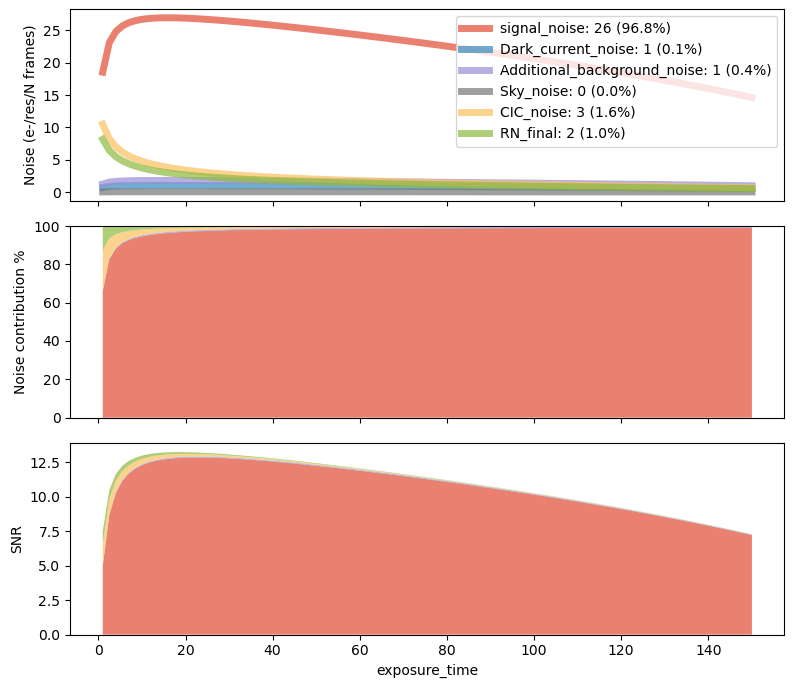

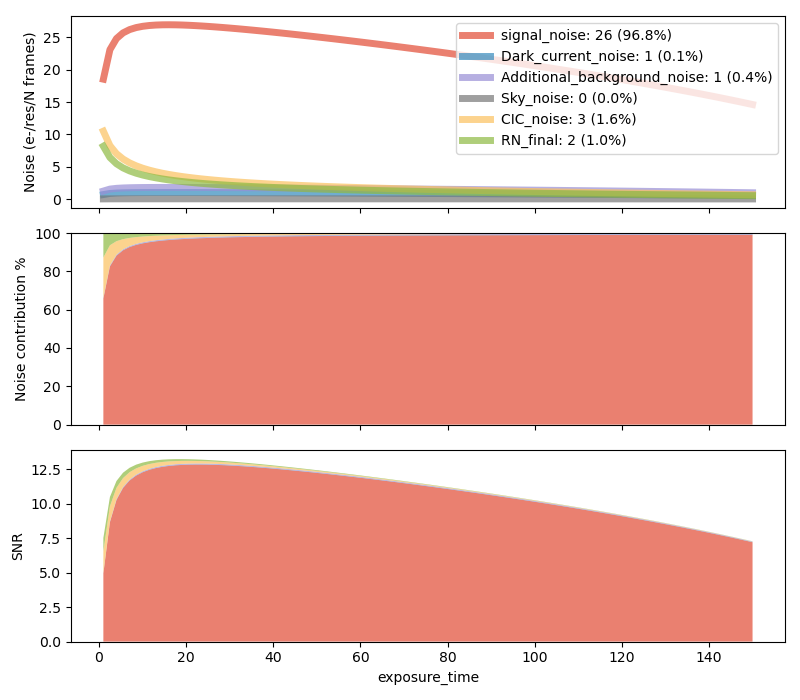

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect

def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    names, varargs, keywords, defaults = inspect.getargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper

#fixed parameters
QE = 0.55
resolution_element=57#microns
pixel_size = 13#microns
Gain_ADU = 0.53 #e-/e-
Throughput = 0.13
Atmosphere = 0.5
colors = ['#E24A33','#348ABD','#988ED5','#777777','#FBC15E','#8EBA42','#FFB5B8']
# CIC_charge = 0.005 # e/pix/frame
# Dard_current = 0.08 # e/pix/hour
# Sky_LU = 10000 # 200 000 in 2018


class Observation:
    @initializer
    def __init__(self, exposure_time=50, counting_mode=False, Signal=1.25E-17, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, flight_background_damping = 0.9, Additional_background_2018 = 0.0007,acquisition_time = 2,coeff_stack=2):
        self.ENF = 2 if counting_mode else 1
        if counting_mode:
            self.Photon_count_loss = 0.7 if readout_time==1.5 else 0.8 #a contraindre...
        else:
            self.Photon_count_loss =  1
        self.cosmic_ray_loss = np.minimum(0.005*exposure_time,1)
        self.QE_efficiency = self.Photon_count_loss * QE#* (1-cosmic_ray_loss)#ne devrait pas etre la 
        self.RN_fraction_kept = 0.05 if counting_mode else 1
        self.RN_final = RN  * self.RN_fraction_kept / EM_gain #Are we sure about that?
        self.CIC_noise = np.sqrt(CIC_charge) if counting_mode else np.sqrt(CIC_charge*2)
        self.Dark_current_f = Dard_current * exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f) if counting_mode else np.sqrt(self.Dark_current_f*2)
        self.Additional_background = Additional_background_2018 * exposure_time *(1-flight_background_damping) # e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background) if counting_mode else np.sqrt(self.Additional_background*2)
        self.lu2ergs = 2.33E-19/1000
        self.Sky_ = Sky_LU*self.lu2ergs#/1000*2.33E-19 # ergs/cm2/s/arcsec^2
        self.factor_el = self.QE_efficiency * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
        self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame

        self.Sky_f =  self.sky * EM_gain * Gain_ADU  # el/pix/frame
        self.Sky_noise = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
        self.N_images = acquisition_time*3600/(exposure_time+readout_time)
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (resolution_element/pixel_size)**2# el/N exposure/resol
        self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el = self.Signal_LU*self.factor_el*exposure_time  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
        # print(Signal )
        # print(self.Signal_LU )
        # print(self.Signal_el )
#         if counting_mode:
#             print('%0.1f < ExpTime < %0.1f' %(0.01/self.factor_el/self.Signal_LU,0.1/self.factor_el/self.Signal_LU))
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (resolution_element/pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el) if counting_mode else np.sqrt(self.Signal_el*2)     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *resolution_element/pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (resolution_element/pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (resolution_element/pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
        self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        n =len(self.Total_noise_final + self.Signal_resolution) 
        if n>1:
            for name in ["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final","Signal_resolution"]:
                setattr(self, name, getattr(self,name)*np.ones(n))
        self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Additional_background_noise*self.factor, self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T

        self.snrs=self.Signal_resolution /self.Total_noise_final
        self.percents =  100* np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2
        # self.percents =  100* np.array(self.noises).T**2/self.Total_noise_final**2



    
        
    def PlotNoise(self,title='',x='exposure_time'):
        # plt.style.use('seaborn')
        lw=5
        fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
        for i,(name,c) in enumerate(zip(["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final"],colors)):
            ax1.plot(getattr(self,x), getattr(self,name)*self.factor,label='%s: %i (%0.1f%%)'%(name,(getattr(self,name)*self.factor)[np.argmax(self.snrs)],self.percents[i,np.argmax(self.snrs)]),lw=lw,alpha=0.7,c=c)
        # ax1.plot(getattr(self,x), getattr(self,"Total_noise_final")*self.factor,label="Total_noise_final", lw=lw,alpha=0.7,c='k')

        ax1.legend(loc='upper right')
        # ax3.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,np.max(self.snrs)],':',c='k')
        # ax2.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,100],':',c='k')
        # ax3.plot(getattr(self,x), self.snrs,lw=0,c='k',label='$SNR_{max}$=%0.1f at t=%i'%(np.max(self.snrs),getattr(self,x)[np.argmax(self.snrs)]))
        # ax3.legend(loc='upper right')
        ax1.grid(False)
        ax2.grid(False)
        ax3.grid(False)
        ax3.stackplot(getattr(self,x), self.snrs * np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2,alpha=0.7,colors=colors)
        ax2.stackplot(getattr(self,x),self.percents,alpha=0.7,colors=colors)
        # stackplot(time,  np.array(self.noises)[:,-1]**2 /np.array(self.noises).T[:1,:]**2)
        # ax2.set_xlim((getattr(self,x).min(),getattr(self,x).max()))
        ax2.set_ylim((0,100))
        # ax1.set_ylim((time.min(),time.max()))
        ax3.set_xlabel(x)
        ax3.set_ylabel('SNR')
        ax2.set_ylabel('Noise contribution %')
        ax1.set_ylabel('Noise (e-/res/N frames)')
        # ax1.set_title(title+'Flux:%s, $t_{aqu}$:%0.1fh, $t_{exp}$:%is, G$_{EM}$:%i, Counting:%s'%(self.Signal,self.acquisition_time,self.exposure_time,self.EM_gain,self.counting_mode))
        fig.tight_layout()
        return fig 
# Nominal = Observation(exposure_time=np.linspace(1,150,100),Sky_LU=1e4, counting_mode=False,Signal=4.55e-16,acquisition_time=0.2)
# Nominal.PlotNoise()
# Nominal = Observation(exposure_time=5,Sky_LU=np.linspace(1,150,100), counting_mode=False,Signal=4.55e-16,acquisition_time=0.2)
# Nominal.PlotNoise(x='Sky_LU')
Nominal = Observation(exposure_time=np.linspace(1,150,100),Sky_LU=5, counting_mode=False,Signal=4.55e-16,acquisition_time=0.2)
# Nominal.PlotNoise()




/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_74269/83517159.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8, 7), sharex=True)


interactive(children=(Dropdown(description='X axis', options=('exposure_time', 'Sky_LU', 'acquisition_time', '…

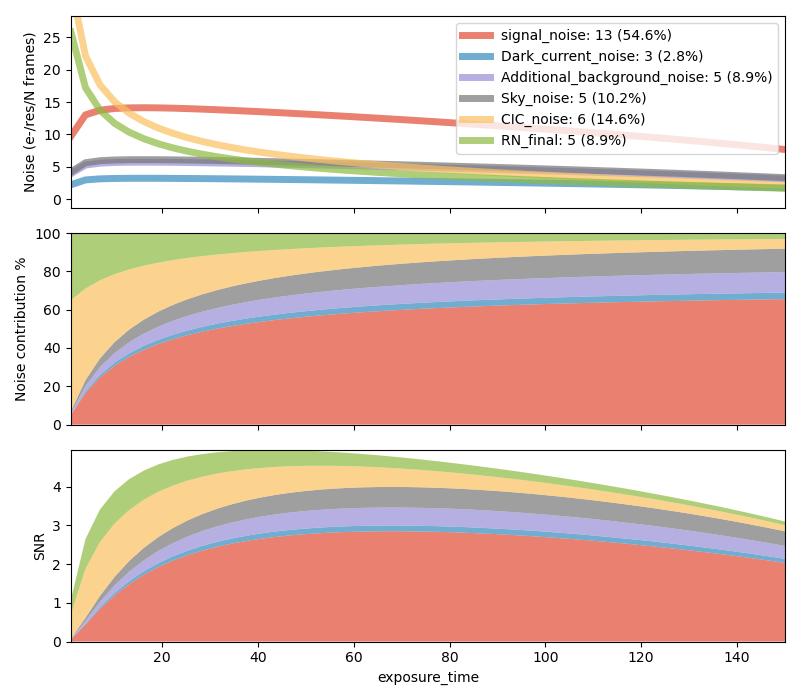

In [26]:
# def make_box_layout():
     # return widgets.Layout()
        # border='solid 1px black',
        # margin='0px 10px 10px 0px',
        # padding='5px 5px 5px 5px',layout = Layout(flex_flow=' row wrap'))
 
class ExposureTimeCalulator(widgets.HBox):
     
    def __init__(self):
        super().__init__()
        output = widgets.Output()
        self.x = Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
 
        # with output:
        # self.fig,_  = plt.subplots(constrained_layout=True, figsize=(15, 3.5))
        self.fig  = Nominal.PlotNoise()
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
        self.ax2 =  self.fig.axes[2]

        # self.line, = self.ax2.plot(self.x, self.x)#Nominal.SNR)
        # self.line, = self.ax.plot(1,1)#Nominal.SNR)

        self.fig.canvas.toolbar_position = 'bottom'
        # self.ax.set_ylim((0,50))
        # self.ax.set_ylabel('SNR')


#         controls = widgets.HBox(wids.children)
#         controls.layout = make_box_layout()
#         out_box = widgets.Box([output])
#         output.layout = make_box_layout()

        style={}#{'description_width': 'initial'}
        exposure_time = widgets.IntSlider( min=1, max=150,value=50, layout=Layout(width='500px'),description='$t_{exp}$ (s)')# style = {'description_width': 'initial'}
        acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=2, layout=Layout(width='500px'),description='$t_{aq}$ (h)')# style = {'description_width': 'initial'}
        Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=4,base=10, style =style, layout=Layout(width='500px'),description='Sky (LU)')
        Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')#,readout_format='.2e')
        EM_gain = widgets.IntSlider( min=200, max=2000,value=1400, style = style, layout=Layout(width='500px'),description='EM_gain')
        RN = widgets.IntSlider( min=30, max=120,value=109, style = style, layout=Layout(width='500px'),description='RN')
        CIC_charge = widgets.FloatSlider( min=0.003, max=0.05,value=0.005,style = style, layout=Layout(width='500px'),description='CIC$_{charge}$',step=0.001,readout_format='.3f')
        Dard_current = widgets.FloatSlider( min=0.01, max=0.2,value=0.08, style = style, layout=Layout(width='500px'),description='Dard$_{current}$',step=0.0011,readout_format='.2f')
        readout_time = widgets.FloatSlider( min=1.5, max=20,value=1.5, style = style, layout=Layout(width='500px'),description=r'RO$_{time}$ (s)',step=0.1)
        x_axis=widgets.Dropdown(options=['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time"],value='exposure_time',description='X axis')
        mode=widgets.Dropdown(options=['Flight 2018','Nominal 2022 10MHz','Nominal 2022 100MHz'],value='Nominal 2022 10MHz',description='X axis')

        
        wids = interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        # controls = HBox(wids.children[:-1], layout = Layout (flex_flow='row wrap'))
        # output = wids.children[-1]
        # display (VBox ( [controls, output]))
        # widgets.interact(self.update,sky=(1e4, 1e6, 100),x_axis=['exposure_time','test'],acquisition_time=(0.1, 10, 0.1),counting_mode=False,Signal=(-18,-16,0.01),EM_gain=(200,2000,1),RN=(30,120,1), CIC_charge=(0.005,0.05,0.001), Dard_current=(0.08,0.2), readout_time=(1.5,15))
    # def __init__(self, exposure_time=50, counting_mode=False, Signal=1.25E-17, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, flight_background_damping = 0.9, Additional_background_2018 = 0.0007,acquisition_time = 2,coeff_stack=2):
        #TODO add other plot:electron spectra
        # add mode, and make widget left to figure
        # depends on temperature?
        # add smearing... FloatRangeSlider
        # self.children = [controls, output]
     
    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time):
        """Draw line in plot"""
        # print(sky)
        if x_axis == 'exposure_time':
            exposure_time=np.linspace(1,150,100)
        elif x_axis == 'Sky_LU':
            Sky_LU=np.linspace(1e4,1e8,100)
        if x_axis == 'exposure_time':
            exposure_time=np.linspace(1,150)
        if x_axis == 'Signal':
            Signal=np.linspace(1e-18,1e-16)
        if x_axis == 'EM_gain':
            EM_gain=np.linspace(200,2000)
        if x_axis == 'acquisition_time':
            acquisition_time=np.linspace(0.1,6)
            
        if x_axis == 'RN':
            RN=np.linspace(30,120,100)
        elif x_axis == 'CIC_charge':
            CIC_charge=np.linspace( 0.003, 0.05)
        if x_axis == 'Dard_current':
            Dard_current=np.linspace(0.01,0.2)
        if x_axis == 'readout_time':
            readout_time=np.linspace(1.5, 20)

        # colors = ['r','g','b','k','orange','brown']
        new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time)
        for i,name in enumerate(["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final"]):
            self.fig.axes[0].lines[i].set_xdata(getattr(new,x_axis))
            self.fig.axes[0].lines[i].set_ydata(getattr(new,name)*new.factor)
            self.fig.axes[0].lines[i].set_label('%s: %i (%0.1f%%)'%(name,(getattr(new,name)*new.factor)[np.argmax(new.snrs)],new.percents[i,np.argmax(new.snrs)]))
        # self.fig.axes[0].lines[-1].set_xdata(getattr(new,x_axis))
        # self.fig.axes[0].lines[-1].set_ydata(getattr(new,"Total_noise_final")*new.factor)

        self.fig.axes[0].legend(loc='upper right')
        self.fig.axes[1].collections.clear()#cla()#
        self.fig.axes[1].stackplot(getattr(new,x_axis),new.percents,alpha=0.7,colors=colors)
        self.fig.axes[2].collections.clear()#cla()#
        self.fig.axes[2].stackplot(getattr(new,x_axis),new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=colors)
        # self.fig.axes[0].lines[0].set_ydata(new.SNR)
        # self.fig.axes[2].lines[0].set_ydata(new.SNR)
        # self.line.set_xdata(getattr(new,x_axis))
        # self.line.set_ydata(new.SNR)
        # self.line.set_data(getattr(new,x_axis),new.SNR)
        self.ax2.set_xlabel(x_axis)
        # self.fig.suptitle('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
        # self.ax2.set_ylim((np.min(new.SNR),1.1*np.max(new.SNR)))
        self.ax2.set_xlim((np.min(getattr(new,x_axis)),np.max(getattr(new,x_axis))))
        self.ax2.set_ylim((0,np.max(getattr(new,'SNR'))))

        # self.fig.canvas.draw()
        return
         
ETC = ExposureTimeCalulator()
# Nominal.SNR